In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import random

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/bprovanbessell/SATfeatPy/main/features_csv/all_features.csv?token=GHSAT0AAAAAABQU4OMZVNM7UJFEOOGDAT6CYQ7SWFA')
df

,c,v,clauses_vars_ratio,vars_clauses_ratio,vcg_var_mean,vcg_var_coeff,vcg_var_min,vcg_var_max,vcg_var_entropy,vcg_clause_mean,...,rwh_1_max,rwh_2_mean,rwh_2_coeff,rwh_2_min,rwh_2_max,file_name,satzilla_base_t,satzilla_probe_t,ansotegui_t,alfonso_t
0,608,71,8.563380,0.116776,0.045172,0.173688,0.029605,0.060855,2.802758,0.045172,...,2113.390083,1081.900778,1.000000,1.302080e-29,2163.801556,/projects/satdb/dataset_final/sat_matching_80_...,0.021469,3.190207,0.155923,73.221281
1,615,70,8.785714,0.113821,0.049617,0.168633,0.032520,0.069919,2.607264,0.049617,...,2414.976852,1186.623627,1.000000,3.491123e-120,2373.247255,/projects/satdb/dataset_final/sat_matching_80_...,0.026595,3.461776,0.186650,71.619842
2,926,105,8.819048,0.113391,0.033385,0.186444,0.017279,0.047516,3.022879,0.033385,...,882.654092,474.697562,1.000000,0.000000e+00,949.395124,/projects/satdb/dataset_final/sat_matching_120...,0.036297,3.868897,0.390993,193.343842
3,603,70,8.614286,0.116086,0.049799,0.133441,0.033167,0.063018,2.688342,0.049799,...,2363.166661,1149.059132,1.000000,4.670090e-147,2298.118264,/projects/satdb/dataset_final/sat_matching_80_...,0.025883,3.470889,0.178437,71.508800
4,228,43,5.302326,0.188596,0.067319,0.162581,0.048246,0.087719,2.203308,0.067319,...,2182.810606,1296.888087,1.000000,6.307424e-06,2593.776167,/projects/satdb/dataset_final/sat_matching_60_...,0.009835,2.575210,0.060785,6.017588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2407,1668,56,29.785714,0.033573,0.056130,0.056969,0.046763,0.062350,2.504465,0.056130,...,13224.016367,6615.279871,1.000000,0.000000e+00,13230.559743,/projects/satdb/dataset_final/unsat_5clique_65...,0.051644,4.666926,0.206252,1114.873592
2408,420,28,15.000000,0.066667,0.107143,0.046765,0.092857,0.114286,1.798018,0.107143,...,25451.130169,12602.458887,1.000000,0.000000e+00,25204.917773,/projects/satdb/dataset_final/unsat_4clique_32...,0.018417,2.658451,0.058986,31.583888
2409,1827,59,30.966102,0.032293,0.052898,0.045194,0.039409,0.055829,2.267027,0.052898,...,12491.897377,6216.493633,1.000000,0.000000e+00,12432.987265,/projects/satdb/dataset_final/unsat_5clique_65...,0.088103,5.107600,0.215623,1373.566005
2410,932,44,21.181818,0.047210,0.064524,0.090983,0.049356,0.074034,2.633887,0.064524,...,15640.147512,7680.635364,1.000000,0.000000e+00,15361.270729,/projects/satdb/dataset_final/unsat_5clique_50...,0.028411,3.433000,0.103281,230.092615


In [3]:
satzilla_base = ['c', 'v', 'clauses_vars_ratio', 'vars_clauses_ratio', 'vcg_var_mean', 'vcg_var_coeff', 'vcg_var_min',
                'vcg_var_max', 'vcg_var_entropy', 'vcg_clause_mean', 'vcg_clause_coeff', 'vcg_clause_min', 'vcg_clause_max',
                'vcg_clause_entropy', 'vg_mean', 'vg_coeff', 'vg_min', 'vg_max', 'pnc_ratio_mean', 'pnc_ratio_coeff',
                'pnc_ratio_min', 'pnc_ratio_max', 'pnc_ratio_entropy', 'pnv_ratio_mean', 'pnv_ratio_coeff', 'pnv_ratio_min',
                'pnv_ratio_max', 'pnv_ratio_entropy', 'pnv_ratio_stdev', 'binary_ratio', 'ternary_ratio', 'ternary+',
                'hc_fraction', 'hc_var_mean', 'hc_var_coeff', 'hc_var_min', 'hc_var_max', 'hc_var_entropy']
satzilla_probing = ['unit_props_at_depth_1', 'unit_props_at_depth_4', 'unit_props_at_depth_16', 'unit_props_at_depth_64',
                    'unit_props_at_depth_256', 'mean_depth_to_contradiction_over_vars', 'estimate_log_number_nodes_over_vars',
                    'saps_BestSolution_Mean', 'saps_BestSolution_CoeffVariance', 'saps_FirstLocalMinStep_Mean',
                    'saps_FirstLocalMinStep_CoeffVariance', 'saps_FirstLocalMinStep_Median', 'saps_FirstLocalMinStep_Q.10',
                    'saps_FirstLocalMinStep_Q.90', 'saps_BestAvgImprovement_Mean', 'saps_BestAvgImprovement_CoeffVariance',
                    'saps_FirstLocalMinRatio_Mean', 'saps_FirstLocalMinRatio_CoeffVariance', 'saps_EstACL_Mean',
                    'gsat_BestSolution_Mean', 'gsat_BestSolution_CoeffVariance', 'gsat_FirstLocalMinStep_Mean',
                    'gsat_FirstLocalMinStep_CoeffVariance', 'gsat_FirstLocalMinStep_Median', 'gsat_FirstLocalMinStep_Q.10',
                    'gsat_FirstLocalMinStep_Q.90', 'gsat_BestAvgImprovement_Mean', 'gsat_BestAvgImprovement_CoeffVariance',
                    'gsat_FirstLocalMinRatio_Mean', 'gsat_FirstLocalMinRatio_CoeffVariance', 'gsat_EstACL_Mean']
ansotegui = ['vig_modularty',
             'vig_d_poly', 'cvig_db_poly', 'variable_alpha']
alfonso = ['v_nd_p_node_min', 'v_nd_p_node_max', 'v_nd_p_node_mode',
           'v_nd_p_node_mean', 'v_nd_p_node_std', 'v_nd_p_node_zeros', 'v_nd_p_node_entropy', 'v_nd_p_node_q1',
           'v_nd_p_node_q2', 'v_nd_p_node_q3', 'v_nd_p_node_val_rate', 'v_nd_p_weights_min', 'v_nd_p_weights_max',
           'v_nd_p_weights_mode', 'v_nd_p_weights_mean', 'v_nd_p_weights_std', 'v_nd_p_weights_zeros',
           'v_nd_p_weights_entropy', 'v_nd_p_weights_q1', 'v_nd_p_weights_q2', 'v_nd_p_weights_q3', 'v_nd_p_weights_val_rate',
           'v_nd_n_node_min', 'v_nd_n_node_max', 'v_nd_n_node_mode', 'v_nd_n_node_mean', 'v_nd_n_node_std',
           'v_nd_n_node_zeros', 'v_nd_n_node_entropy', 'v_nd_n_node_q1', 'v_nd_n_node_q2', 'v_nd_n_node_q3',
           'v_nd_n_node_val_rate', 'v_nd_n_weights_min', 'v_nd_n_weights_max', 'v_nd_n_weights_mode', 'v_nd_n_weights_mean',
           'v_nd_n_weights_std', 'v_nd_n_weights_zeros', 'v_nd_n_weights_entropy', 'v_nd_n_weights_q1', 'v_nd_n_weights_q2',
           'v_nd_n_weights_q3', 'v_nd_n_weights_val_rate', 'c_nd_p_node_min', 'c_nd_p_node_max', 'c_nd_p_node_mode',
           'c_nd_p_node_mean', 'c_nd_p_node_std', 'c_nd_p_node_zeros', 'c_nd_p_node_entropy', 'c_nd_p_node_q1',
           'c_nd_p_node_q2', 'c_nd_p_node_q3', 'c_nd_p_node_val_rate', 'c_nd_p_weights_min', 'c_nd_p_weights_max',
           'c_nd_p_weights_mode', 'c_nd_p_weights_mean', 'c_nd_p_weights_std', 'c_nd_p_weights_zeros',
           'c_nd_p_weights_entropy', 'c_nd_p_weights_q1', 'c_nd_p_weights_q2', 'c_nd_p_weights_q3', 'c_nd_p_weights_val_rate',
           'c_nd_n_node_min', 'c_nd_n_node_max', 'c_nd_n_node_mode', 'c_nd_n_node_mean', 'c_nd_n_node_std',
           'c_nd_n_node_zeros', 'c_nd_n_node_entropy', 'c_nd_n_node_q1', 'c_nd_n_node_q2', 'c_nd_n_node_q3',
           'c_nd_n_node_val_rate', 'c_nd_n_weights_min', 'c_nd_n_weights_max', 'c_nd_n_weights_mode', 'c_nd_n_weights_mean',
           'c_nd_n_weights_std', 'c_nd_n_weights_zeros', 'c_nd_n_weights_entropy', 'c_nd_n_weights_q1', 'c_nd_n_weights_q2',
           'c_nd_n_weights_q3', 'c_nd_n_weights_val_rate', 'vg_al_node_min', 'vg_al_node_max', 'vg_al_node_mode',
           'vg_al_node_mean', 'vg_al_node_std', 'vg_al_node_zeros', 'vg_al_node_entropy', 'vg_al_node_q1', 'vg_al_node_q2',
           'vg_al_node_q3', 'vg_al_node_val_rate', 'vg_al_weights_min', 'vg_al_weights_max', 'vg_al_weights_mode',
           'vg_al_weights_mean', 'vg_al_weights_std', 'vg_al_weights_zeros', 'vg_al_weights_entropy', 'vg_al_weights_q1',
           'vg_al_weights_q2', 'vg_al_weights_q3', 'vg_al_weights_val_rate', 'cg_al_node_min', 'cg_al_node_max',
           'cg_al_node_mode', 'cg_al_node_mean', 'cg_al_node_std', 'cg_al_node_zeros', 'cg_al_node_entropy', 'cg_al_node_q1',
           'cg_al_node_q2', 'cg_al_node_q3', 'cg_al_node_val_rate', 'cg_al_weights_min', 'cg_al_weights_max',
           'cg_al_weights_mode', 'cg_al_weights_mean', 'cg_al_weights_std', 'cg_al_weights_zeros', 'cg_al_weights_entropy',
           'cg_al_weights_q1', 'cg_al_weights_q2', 'cg_al_weights_q3', 'cg_al_weights_val_rate', 'rg_node_min', 'rg_node_max',
           'rg_node_mode', 'rg_node_mean', 'rg_node_std', 'rg_node_zeros', 'rg_node_entropy', 'rg_node_q1', 'rg_node_q2',
           'rg_node_q3', 'rg_node_val_rate', 'rg_weights_min', 'rg_weights_max', 'rg_weights_mode', 'rg_weights_mean',
           'rg_weights_std', 'rg_weights_zeros', 'rg_weights_entropy', 'rg_weights_q1', 'rg_weights_q2', 'rg_weights_q3',
           'rg_weights_val_rate', 'big_node_min', 'big_node_max', 'big_node_mode', 'big_node_mean', 'big_node_std',
           'big_node_zeros', 'big_node_entropy', 'big_node_q1', 'big_node_q2', 'big_node_q3', 'big_node_val_rate',
           'big_weights_min', 'big_weights_max', 'big_weights_mode', 'big_weights_mean', 'big_weights_std',
           'big_weights_zeros', 'big_weights_entropy', 'big_weights_q1', 'big_weights_q2', 'big_weights_q3',
           'big_weights_val_rate', 'and_node_min', 'and_node_max', 'and_node_mode', 'and_node_mean', 'and_node_std',
           'and_node_zeros', 'and_node_entropy', 'and_node_q1', 'and_node_q2', 'and_node_q3', 'and_node_val_rate',
           'and_weights_min', 'and_weights_max', 'and_weights_mode', 'and_weights_mean', 'and_weights_std',
           'and_weights_zeros', 'and_weights_entropy', 'and_weights_q1', 'and_weights_q2', 'and_weights_q3',
           'and_weights_val_rate', 'band_node_min', 'band_node_max', 'band_node_mode', 'band_node_mean', 'band_node_std',
           'band_node_zeros', 'band_node_entropy', 'band_node_q1', 'band_node_q2', 'band_node_q3', 'band_node_val_rate',
           'band_weights_min', 'band_weights_max', 'band_weights_mode', 'band_weights_mean', 'band_weights_std',
           'band_weights_zeros', 'band_weights_entropy', 'band_weights_q1', 'band_weights_q2', 'band_weights_q3',
           'band_weights_val_rate', 'exo_node_min', 'exo_node_max', 'exo_node_mode', 'exo_node_mean', 'exo_node_std',
           'exo_node_zeros', 'exo_node_entropy', 'exo_node_q1', 'exo_node_q2', 'exo_node_q3', 'exo_node_val_rate',
           'exo_weights_min', 'exo_weights_max', 'exo_weights_mode', 'exo_weights_mean', 'exo_weights_std',
           'exo_weights_zeros', 'exo_weights_entropy', 'exo_weights_q1', 'exo_weights_q2', 'exo_weights_q3',
           'exo_weights_val_rate', 'rwh_0_mean', 'rwh_0_coeff', 'rwh_0_min', 'rwh_0_max', 'rwh_1_mean', 'rwh_1_coeff',
           'rwh_1_min', 'rwh_1_max', 'rwh_2_mean', 'rwh_2_coeff', 'rwh_2_min', 'rwh_2_max']

In [4]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.fillna(0)
df = df.reset_index(drop=True)

In [5]:
y_sat = []

for path in df['file_name']:
    name = path.split('/')[-1]
    if name[0] == 's':
        y_sat.append(0)
    elif name[0] == 'u':
        y_sat.append(1)

for i in random.sample(range(0,2000), 10):
    print(df['file_name'][i],y_sat[i])

/projects/satdb/dataset_final/unsat_tiling_20_776_37349.cnf 1
/projects/satdb/dataset_final/unsat_op_90_775_77356.cnf 1
/projects/satdb/dataset_final/sat_op_28_119_93390.cnf 0
/projects/satdb/dataset_final/sat_php_229_953_24423.cnf 0
/projects/satdb/dataset_final/unsat_php_183_1607_78552.cnf 1
/projects/satdb/dataset_final/sat_tseitin_40_290_90668.cnf 0
/projects/satdb/dataset_final/unsat_tseitin_30_440_19861.cnf 1
/projects/satdb/dataset_final/unsat_op_90_775_86518.cnf 1
/projects/satdb/dataset_final/sat_3clique_39_627_64175.cnf 0
/projects/satdb/dataset_final/sat_4color_200_950_43140.cnf 0


In [6]:
y_category = []

dictionary = {
    'cliquecoloring' : 0,
    'kclique' : 1,
    'kcolor' : 2,
    'tseitin' : 3,
    'php' : 4,
    'matching' : 5,
    'tiling' : 6,
    'subsetcard' : 7,
    'op' : 8,
    'dominating' : 9
}

for path in df['file_name']:
    name = path.split('/')[-1]
    cat = name.split('_')[1]
    if ('color' in cat) and (cat != 'cliquecoloring'):
        cat = 'kcolor'
    elif ('clique' in cat) and (cat != 'cliquecoloring'):
        cat = 'kclique'
    y_category.append(dictionary[cat])

for i in random.sample(range(0,2000), 10):
    print(df['file_name'][i],y_category[i])

/projects/satdb/dataset_final/unsat_4color_40_150_78403.cnf 2
/projects/satdb/dataset_final/unsat_tseitin_20_130_34926.cnf 3
/projects/satdb/dataset_final/sat_3clique_24_231_16.cnf 1
/projects/satdb/dataset_final/sat_4color_200_1150_64397.cnf 2
/projects/satdb/dataset_final/unsat_op_90_775_77579.cnf 8
/projects/satdb/dataset_final/sat_dominating_60_970_47815.cnf 9
/projects/satdb/dataset_final/unsat_3color_150_650_37803.cnf 2
/projects/satdb/dataset_final/sat_dominating_40_455_52694.cnf 9
/projects/satdb/dataset_final/sat_cliquecoloring_75_469.cnf 0
/projects/satdb/dataset_final/sat_5color_100_620_23477.cnf 2


In [7]:
def calculate_accuracy_rnd_forest(df, y1, scaling):

    X = df  # Features
    y = y1 # Target variable
    scaler = MinMaxScaler()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
    if scaling == True:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    clf = RandomForestClassifier(n_estimators=10)

    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)

    score = metrics.accuracy_score(y_test, y_pred)
    return clf, score

In [8]:
def calculate_accuracy_xgboost(df, y1, scaling):

    X = df  # Features
    y = y1 # Target variable
    scaler = MinMaxScaler()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
    if scaling == True:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    xgb_clf = XGBClassifier(verbosity = 0)

    clf = xgb_clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)

    score = metrics.accuracy_score(y_test, y_pred)
    return clf, score

In [9]:
satzilla = satzilla_base + satzilla_probing
all = satzilla_base + satzilla_probing + ansotegui + alfonso

features_list = [satzilla_base, satzilla, ansotegui, alfonso, all]
name_features = ['satzilla_base', 'full_satzilla', 'antonsegui', 'alfonso', 'all']

print("RANDOM FOREST: ")
for i,features in enumerate(features_list):
    clf, accuracy_sat = calculate_accuracy_rnd_forest(df[features], y_sat, False)
    clf, accuracy_cat = calculate_accuracy_rnd_forest(df[features], y_category, False)
    print("SAT/UNSAT Accuracy for " + name_features[i] + ": ",accuracy_sat)
    print("Category Accuracy for " + name_features[i] + ": ",accuracy_cat)

RANDOM FOREST: 
SAT/UNSAT Accuracy for satzilla_base:  0.9005524861878453
Category Accuracy for satzilla_base:  0.9917127071823204
SAT/UNSAT Accuracy for full_satzilla:  0.9917127071823204
Category Accuracy for full_satzilla:  0.9930939226519337
SAT/UNSAT Accuracy for antonsegui:  0.8342541436464088
Category Accuracy for antonsegui:  0.9323204419889503
SAT/UNSAT Accuracy for alfonso:  0.888121546961326
Category Accuracy for alfonso:  0.9972375690607734
SAT/UNSAT Accuracy for all:  0.9903314917127072
Category Accuracy for all:  0.9958563535911602


# K - Fold Cross-validation

In [10]:
def k_cross_validation(n_splits, n_repeats, algorithm, df, y1):

    X = df
    y = y1
    scaler = MinMaxScaler()
    # pipeline = Pipeline([('transformer', scaler), ('estimator', algorithm)])
    pipeline = Pipeline([('estimator', algorithm)])
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
    # np.save('scores_10fold_satzilla_full_test.npy', scores)
    mean = np.mean(scores)
    std = np.std(scores)
    return scores, mean, std

In [11]:
clf = RandomForestClassifier(n_estimators=10)
xgb_clf = XGBClassifier(verbose=0)


print("RANDOM FOREST: ")
for i,features in enumerate(features_list):
    scores_sat, mean_sat, std_sat = k_cross_validation(10, 10, clf, df[features], y_sat)
    scores_cat, mean_cat, std_cat = k_cross_validation(10, 10, clf, df[features], y_category)
    print('SAT/UNSAT Accuracy ' + name_features[i] + ' : %.4f (%.4f)' % (mean_sat, std_sat))
    print('Category Accuracy ' + name_features[i] + ' : %.4f (%.4f)' % (mean_cat, std_cat))


print("XGBOOST: ")
for i,features in enumerate(features_list):
    scores_sat, mean_sat, std_sat = k_cross_validation(10, 10, xgb_clf, df[features], y_sat)
    scores_cat, mean_cat, std_cat = k_cross_validation(10, 10, xgb_clf, df[features], y_category)
    print('SAT/UNSAT Accuracy ' + name_features[i] + ' : %.4f (%.4f)' % (mean_sat, std_sat))
    print('Category Accuracy ' + name_features[i] + ' : %.4f (%.4f)' % (mean_cat, std_cat))

RANDOM FOREST: 
SAT/UNSAT Accuracy satzilla_base : 0.9138 (0.0162)
Category Accuracy satzilla_base : 0.9961 (0.0045)
SAT/UNSAT Accuracy full_satzilla : 0.9951 (0.0051)
Category Accuracy full_satzilla : 0.9961 (0.0041)
SAT/UNSAT Accuracy antonsegui : 0.8616 (0.0218)
Category Accuracy antonsegui : 0.9319 (0.0171)
SAT/UNSAT Accuracy alfonso : 0.9192 (0.0167)
Category Accuracy alfonso : 0.9976 (0.0032)
SAT/UNSAT Accuracy all : 0.9910 (0.0060)
Category Accuracy all : 0.9982 (0.0024)
XGBOOST: 
SAT/UNSAT Accuracy satzilla_base : 0.9234 (0.0169)
Category Accuracy satzilla_base : 0.9963 (0.0043)
SAT/UNSAT Accuracy full_satzilla : 0.9954 (0.0045)
Category Accuracy full_satzilla : 0.9967 (0.0037)
SAT/UNSAT Accuracy antonsegui : 0.8623 (0.0220)
Category Accuracy antonsegui : 0.9312 (0.0156)
SAT/UNSAT Accuracy alfonso : 0.9473 (0.0139)
Category Accuracy alfonso : 0.9966 (0.0034)
SAT/UNSAT Accuracy all : 0.9952 (0.0044)
Category Accuracy all : 0.9979 (0.0029)


# Features Importance Plot

In [12]:
def features_importance(df, y1, features, name_features, plttype, scaling):

    X = df  # Features
    y = y1 # Target variable
    scaler = MinMaxScaler()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
    if scaling == True:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    clf = RandomForestClassifier(n_estimators=10000)

    clf = clf.fit(X_train,y_train)

    importances = clf.feature_importances_
    # Sort feature importances in descending order
    indices = np.argsort(importances)
    # Rearrange feature names so they match the sorted feature importances
    names = [features[i] for i in indices]

    feat_importances = pd.Series(importances, index=names)
    x = feat_importances.nlargest(10).sort_values(ascending=True)
    print(x)

    # Barplot: Add bars
    plt.figure(figsize=(10,5))
    plt.barh(range(x.shape[0]), x)
    # Add feature names as x-axis labels
    plt.yticks(range(x.shape[0]), x.keys(), rotation=0, fontsize = 15)
    # Create plot title
    plt.title("feature importance for " + plttype + " classification - "+str(name_features))
    # Show plot
    plt.show()

exo_weights_val_rate       0.009452
v_nd_p_node_zeros          0.010947
exo_node_min               0.021446
c_nd_n_weights_val_rate    0.022570
v_nd_n_weights_mode        0.037974
v_nd_n_weights_max         0.090856
v_nd_n_weights_min         0.091049
vg_al_weights_max          0.091631
c_nd_p_weights_entropy     0.092316
cg_al_weights_zeros        0.104033
dtype: float64


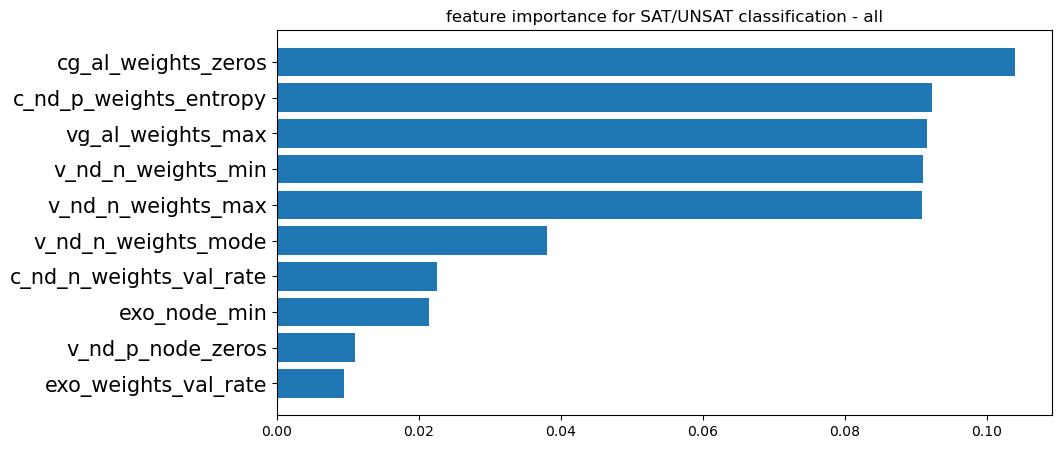

In [13]:
for i,features in enumerate(features_list):
    if i == 4:
        
        features_importance(df[features],y_sat, features, name_features[i], 'SAT/UNSAT', False)

pnv_ratio_coeff       0.034917
vg_max                0.035801
vcg_clause_entropy    0.038792
pnv_ratio_mean        0.042466
vcg_var_entropy       0.043098
vcg_var_mean          0.044257
pnc_ratio_coeff       0.050127
hc_var_coeff          0.055985
ternary_ratio         0.057459
vcg_var_coeff         0.061336
dtype: float64


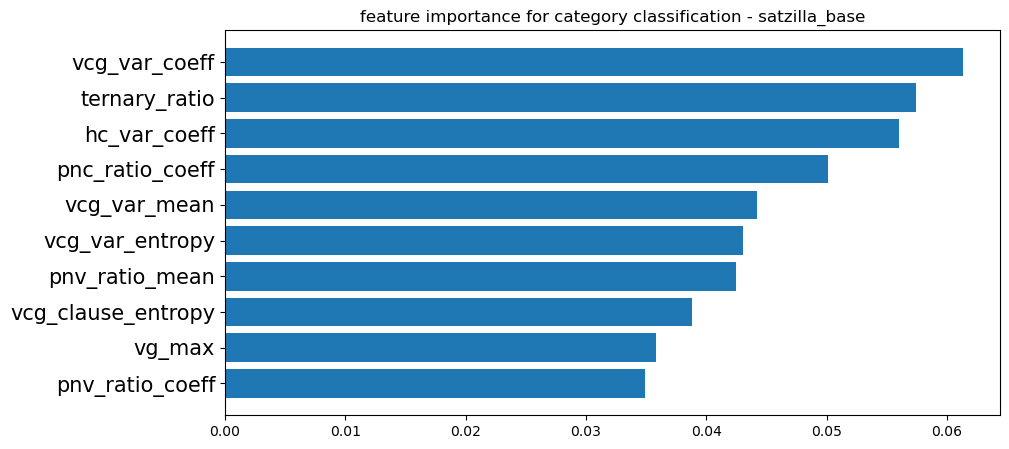

vcg_var_min                      0.029021
pnc_ratio_entropy                0.030444
saps_FirstLocalMinStep_Median    0.030895
saps_FirstLocalMinRatio_Mean     0.031836
saps_BestAvgImprovement_Mean     0.032560
hc_var_coeff                     0.035057
unit_props_at_depth_16           0.040625
saps_FirstLocalMinStep_Q.90      0.045413
hc_var_min                       0.046462
pnv_ratio_coeff                  0.048786
dtype: float64


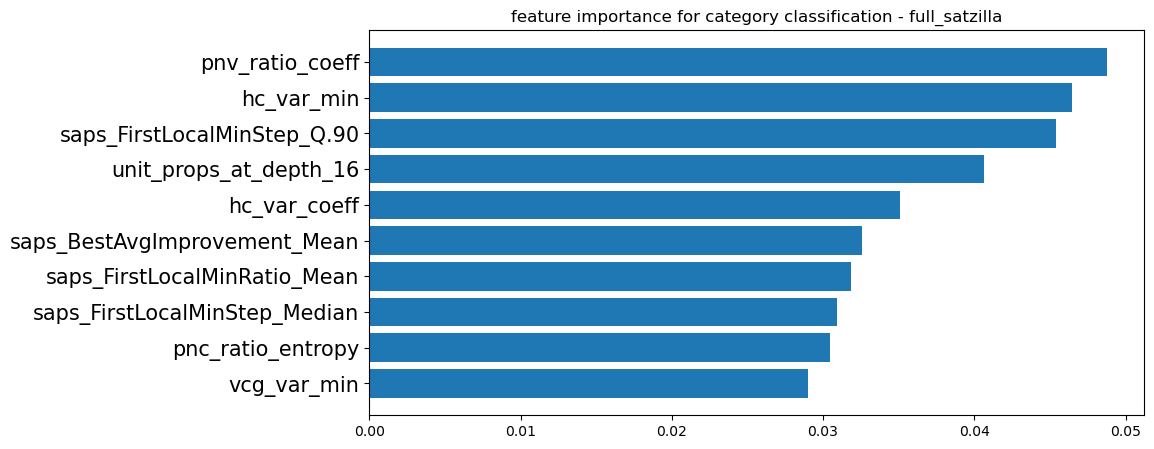

vig_d_poly        0.160039
vig_modularty     0.179696
variable_alpha    0.292040
cvig_db_poly      0.368225
dtype: float64


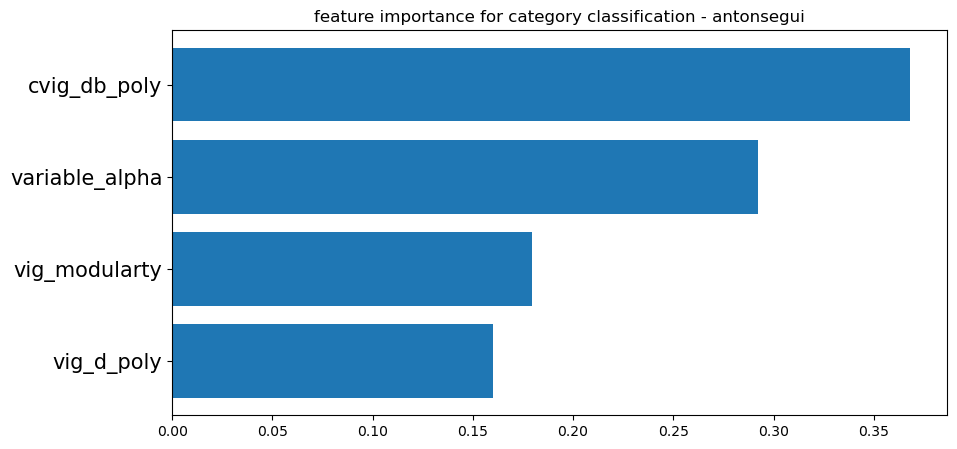

cg_al_weights_max       0.014894
big_node_entropy        0.017993
v_nd_p_weights_q2       0.018418
and_weights_q3          0.018752
c_nd_p_node_max         0.020553
c_nd_n_node_val_rate    0.020620
vg_al_weights_min       0.021397
vg_al_weights_mode      0.022873
band_node_max           0.023095
vg_al_node_entropy      0.023563
dtype: float64


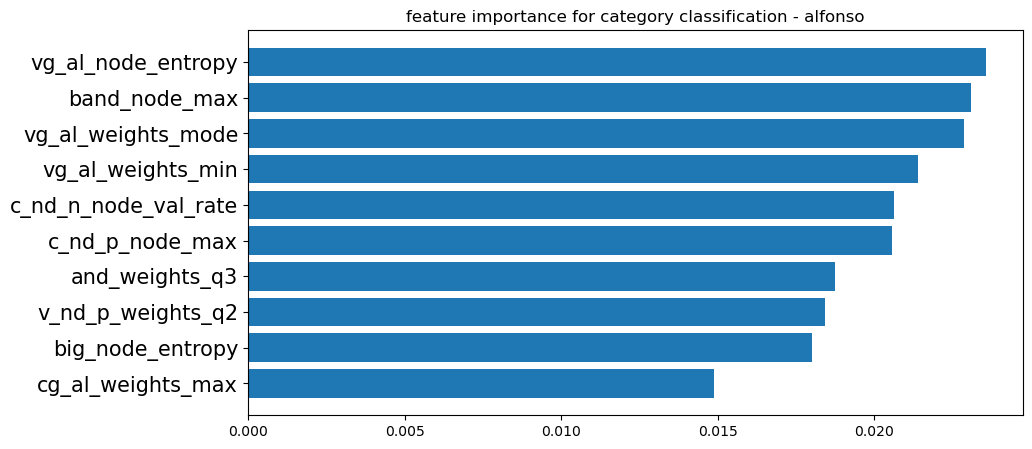

saps_FirstLocalMinStep_Mean             0.015424
v_nd_p_node_mean                        0.016489
band_node_q1                            0.016654
v_nd_p_node_zeros                       0.017340
v_nd_n_weights_q1                       0.017964
rg_weights_std                          0.018226
c_nd_p_node_q3                          0.018753
big_weights_zeros                       0.019563
v_nd_n_node_std                         0.019866
gsat_FirstLocalMinStep_CoeffVariance    0.020711
dtype: float64


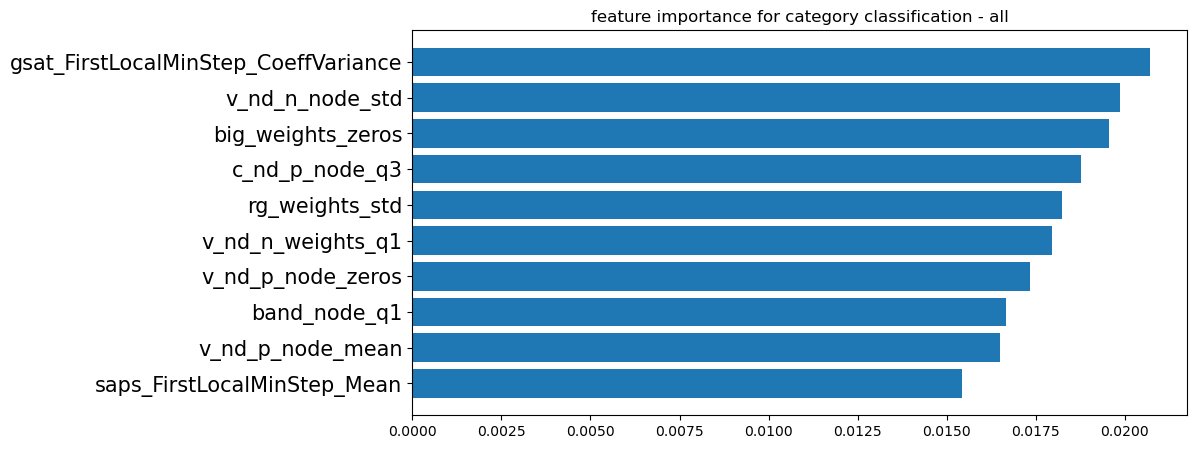

In [14]:
for i,features in enumerate(features_list):
    features_importance(df[features],y_category, features, name_features[i],  'category', False)

In [23]:
import shap
import copy

def plot_shap(X, y, type):
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train a random forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Compute SHAP values
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_test)

    if type == 'SAT':
        classname = ['SAT', 'UNSAT']
    elif type == 'category':
        classname = [
            'cliquecoloring','kclique','kcolor', 'tseitin', 'php', 'matching' ,'tiling', 'subsetcard','op', 'dominating']

    # Plot summary plot
    shap.summary_plot(shap_values, X_test, class_names=classname, plot_type="bar")

    # Plot dependence plot for selected feature
    shap.dependence_plot('gsat_BestSolution_Mean', shap_values[1], X_test)

    # Plot beeswarm plot for all dataset
    explainer1 = shap.TreeExplainer(clf, X_test)
    shap_values1 = explainer1(X_test)

    shap_values2 = copy.deepcopy(shap_values1)
    shap_values2.values = shap_values2.values[:,:,1]
    shap_values2.base_values = shap_values2.base_values[:,1]

    shap.plots.beeswarm(shap_values2, max_display=10)

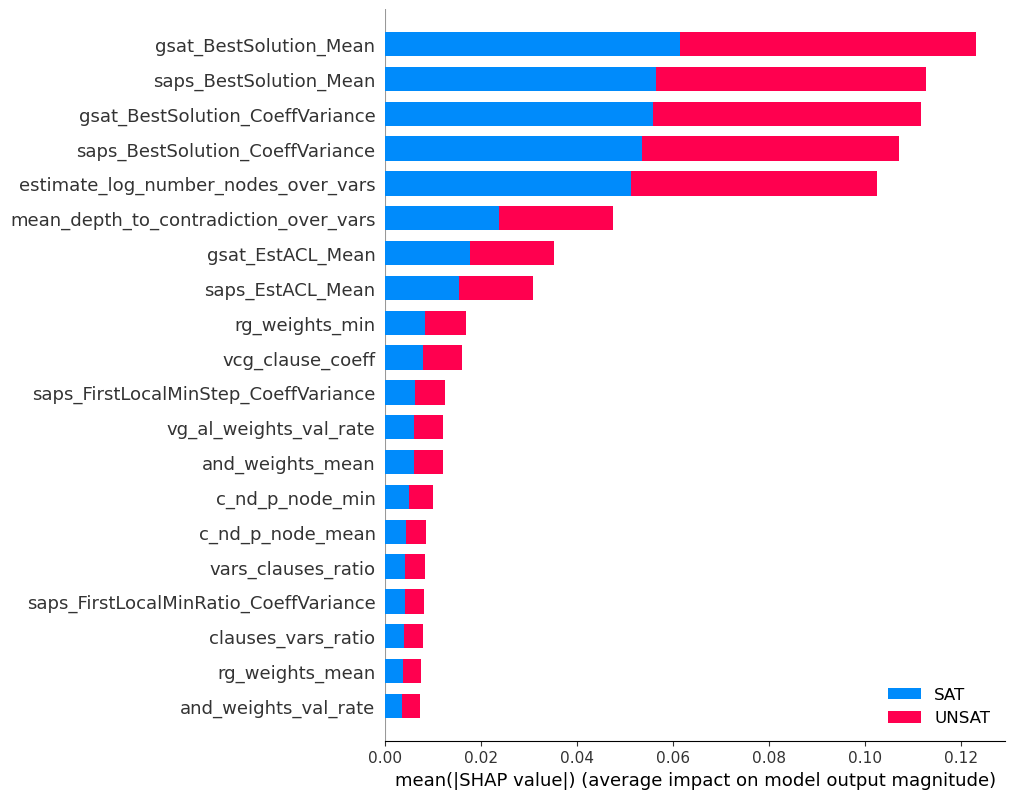

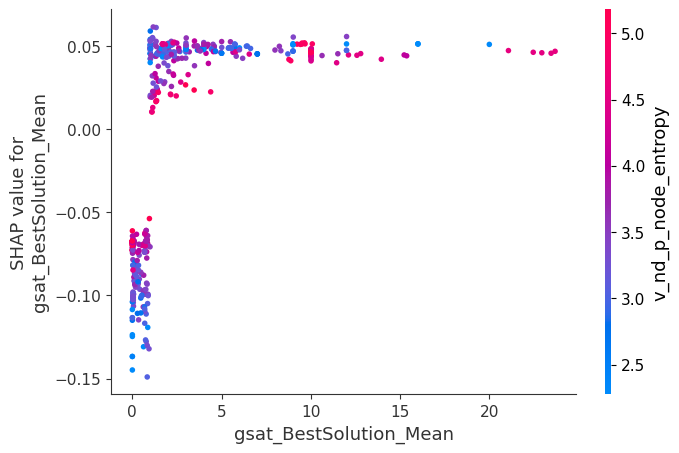

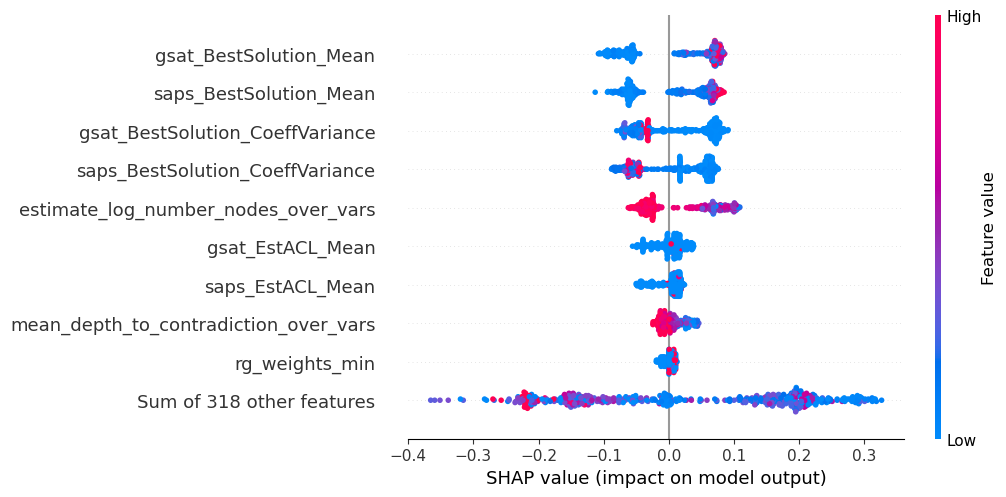

In [24]:
X = df[features]
y = y_sat

plot_shap(X, y, 'SAT')

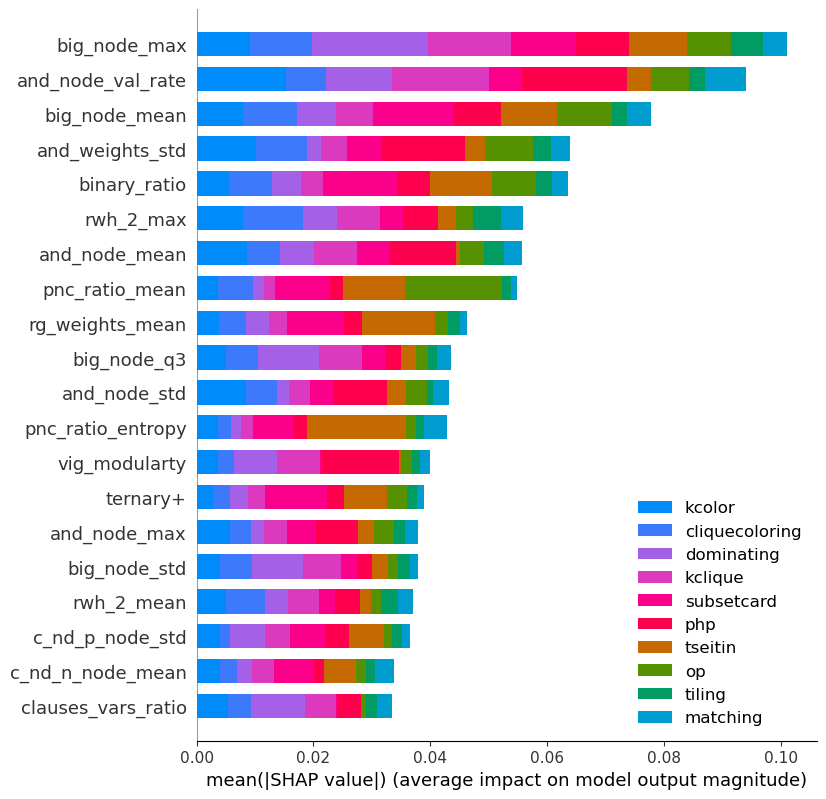

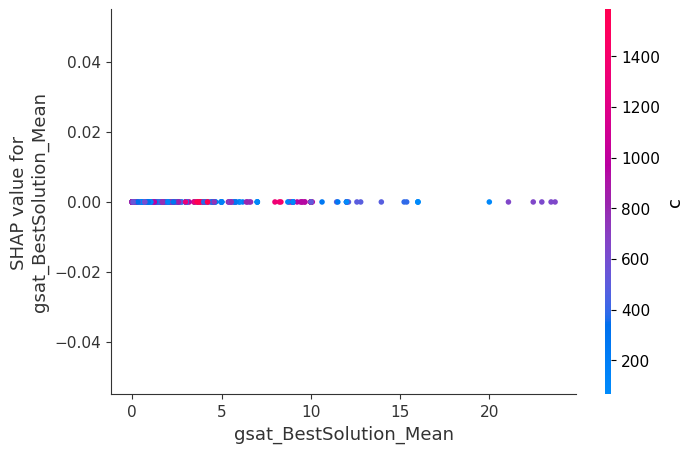

 99%|===================| 4764/4830 [00:21<00:00]        

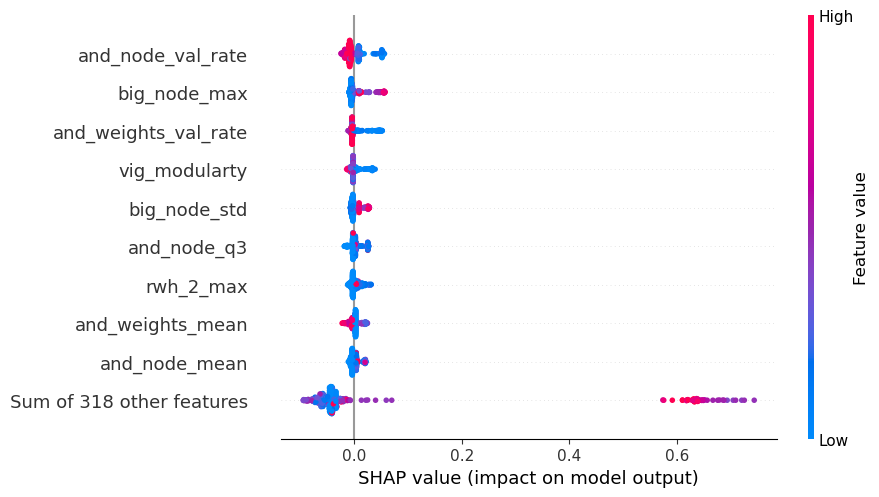

In [25]:
X = df[features]
y = y_category

plot_shap(X, y, 'category')

# Feature Computation Time Graph

In [ ]:
df_rand = pd.read_csv('https://raw.githubusercontent.com/bprovanbessell/SATfeatPy/main/features_csv/rand_features.csv?token=GHSAT0AAAAAABQU4OMYHW6IZXQ7CI5VELQAYRAUJEQ')
df_rand

,c,v,clauses_vars_ratio,vars_clauses_ratio,vcg_var_mean,vcg_var_coeff,vcg_var_min,vcg_var_max,vcg_var_entropy,vcg_clause_mean,vcg_clause_coeff,vcg_clause_min,vcg_clause_max,vcg_clause_entropy,vg_mean,vg_coeff,vg_min,vg_max,pnc_ratio_mean,pnc_ratio_coeff,pnc_ratio_min,pnc_ratio_max,pnc_ratio_entropy,pnv_ratio_mean,pnv_ratio_coeff,pnv_ratio_min,pnv_ratio_max,pnv_ratio_entropy,pnv_ratio_stdev,binary_ratio,ternary_ratio,ternary+,hc_fraction,hc_var_mean,hc_var_coeff,hc_var_min,hc_var_max,hc_var_entropy,unit_props_at_depth_1,unit_props_at_depth_4,...,band_weights_val_rate,exo_node_min,exo_node_max,exo_node_mode,exo_node_mean,exo_node_std,exo_node_zeros,exo_node_entropy,exo_node_q1,exo_node_q2,exo_node_q3,exo_node_val_rate,exo_weights_min,exo_weights_max,exo_weights_mode,exo_weights_mean,exo_weights_std,exo_weights_zeros,exo_weights_entropy,exo_weights_q1,exo_weights_q2,exo_weights_q3,exo_weights_val_rate,rwh_0_mean,rwh_0_coeff,rwh_0_min,rwh_0_max,rwh_1_mean,rwh_1_coeff,rwh_1_min,rwh_1_max,rwh_2_mean,rwh_2_coeff,rwh_2_min,rwh_2_max,file_name,satzilla_base_t,satzilla_probe_t,ansotegui_t,alfonso_t
0,793,185,4.286486,0.233291,0.016468,0.288842,0.005044,0.032787,2.690539,0.016468,0.076675,0.016216,0.027027,0.188410,0.031110,0.275063,0.010088,0.058008,0.497226,0.592617,0.000000,1.0,0.736236,0.232747,0.767942,0.0,1.000000,3.184050,0.178736,0.0,0.958386,0.958386,0.476671,0.007784,0.416085,0.000000,0.017654,2.276873,0.0,0.000000,...,0.500228,0,0,0,0.0,0.0,0,NaN,0.0,0.0,0.0,1.0,0,0,0,0.0,0.0,0,NaN,0,0,0,1.0,546875.0,0.142857,468750.0,625000.0,0.000465,0.050944,0.000441,0.000488,0.000544,0.033993,0.000526,0.000563,/projects/satdb/random/sat_rand3cnf_190_798_17...,0.025876,4.240341,0.513821,58.661260
1,917,213,4.305164,0.232279,0.014300,0.295745,0.004362,0.028353,2.686188,0.014300,0.068637,0.014085,0.018779,0.185962,0.027247,0.285396,0.008724,0.054526,0.495456,0.584898,0.000000,1.0,0.734097,0.241432,0.724854,0.0,1.000000,3.233121,0.175003,0.0,0.954198,0.954198,0.483097,0.006850,0.400047,0.001091,0.017448,2.277607,0.0,0.000000,...,0.500392,0,0,0,0.0,0.0,0,NaN,0.0,0.0,0.0,1.0,0,0,0,0.0,0.0,0,NaN,0,0,0,1.0,359375.0,0.130435,312500.0,406250.0,0.000440,0.243067,0.000333,0.000547,0.000376,0.347549,0.000245,0.000506,/projects/satdb/random/sat_rand3cnf_220_924_62...,0.028931,4.694620,0.673316,82.687405
2,251,59,4.254237,0.235060,0.051185,0.207581,0.027888,0.079681,2.257345,0.051185,0.046268,0.050847,0.067797,0.097729,0.083328,0.193721,0.047809,0.123506,0.503320,0.579566,0.000000,1.0,0.636596,0.195152,0.725774,0.0,0.555556,2.901079,0.141636,0.0,0.980080,0.980080,0.486056,0.024715,0.345842,0.007968,0.043825,2.084204,0.0,0.000000,...,0.503765,0,0,0,0.0,0.0,0,NaN,0.0,0.0,0.0,1.0,0,0,0,0.0,0.0,0,NaN,0,0,0,1.0,390625.0,0.000000,390625.0,390625.0,0.067620,0.176201,0.055705,0.079535,0.044741,0.219838,0.034906,0.054577,/projects/satdb/random/unsat_rand3cnf_60_252_3...,0.012261,2.638673,0.095777,4.711840
3,294,70,4.200000,0.238095,0.042857,0.271768,0.020408,0.071429,2.491447,0.042857,0.000000,0.042857,0.042857,0.000000,0.072886,0.241016,0.034014,0.115646,0.492063,0.577050,0.333333,1.0,0.548874,0.262174,0.839495,0.0,1.000000,3.108827,0.220094,0.0,1.000000,1.000000,0.459184,0.019679,0.455320,0.000000,0.040816,2.300119,0.0,0.014286,...,0.502451,0,0,0,0.0,0.0,0,NaN,0.0,0.0,0.0,1.0,0,0,0,0.0,0.0,0,NaN,0,0,0,1.0,390625.0,0.200000,312500.0,468750.0,0.050174,0.219196,0.039176,0.061172,0.024011,0.271696,0.017488,0.030535,/projects/satdb/random/sat_rand3cnf_70_294_626...,0.014526,2.813540,0.142467,7.244964
4,210,50,4.200000,0.238095,0.060000,0.233285,0.028571,0.080952,2.315103,0.060000,0.000000,0.060000,0.060000,0.000000,0.096381,0.207406,0.052381,0.138095,0.501587,0.577339,0.333333,1.0,0.564936,0.205558,0.749279,0.0,0.666667,2.700981,0.154021,0.0,1.000000,1.000000,0.485714,0.029143,0.326209,0.004762,0.047619,1.896824,0.0,0.000000,...,0.501757,0,0,0,0.0,0.0,0,NaN,0.0,0.0,0.0,1.0,0,0,0,0.0,0.0,0,NaN,0,0,0,1.0,585937.5,0.333333,390625.0,781250.0,0.075778,0.219941,0.059111,0

In [ ]:
cnf_size = []

for path in df_rand['file_name']:
    name = path.split('/')[-1]
    tokens = name.split('_')
    size = int(tokens[2])
    cnf_size.append(size)

for i in random.sample(range(0,100), 10):
    print(df_rand['file_name'][i],cnf_size[i])

/projects/satdb/random/sat_rand3cnf_240_1008_62681.cnf 240
/projects/satdb/random/unsat_rand3cnf_230_966_31942.cnf 230
/projects/satdb/random/sat_rand3cnf_290_1218_62681.cnf 290
/projects/satdb/random/sat_rand3cnf_80_336_17079.cnf 80
/projects/satdb/random/unsat_rand3cnf_150_630_86361.cnf 150
/projects/satdb/random/sat_rand3cnf_270_1134_79628.cnf 270
/projects/satdb/random/sat_rand3cnf_40_168_39063.cnf 40
/projects/satdb/random/sat_rand3cnf_280_1176_86361.cnf 280
/projects/satdb/random/unsat_rand3cnf_130_546_718.cnf 130
/projects/satdb/random/sat_rand3cnf_120_504_49089.cnf 120


In [ ]:
def get_mean_std(X,Y):
    Z = [x for _,x in sorted(zip(Y,X), key=lambda pair : pair[0])]
    Z = np.reshape(Z, (29,10))
    Y.sort()
    Y = np.reshape(Y, (29,10))

    x = []
    y = []
    std = []
    for i in range(29):
        x.append(Y[i][0])
        y.append(np.mean(Z[i]))
        std.append(np.std(Z[i]))

    return x,y,std

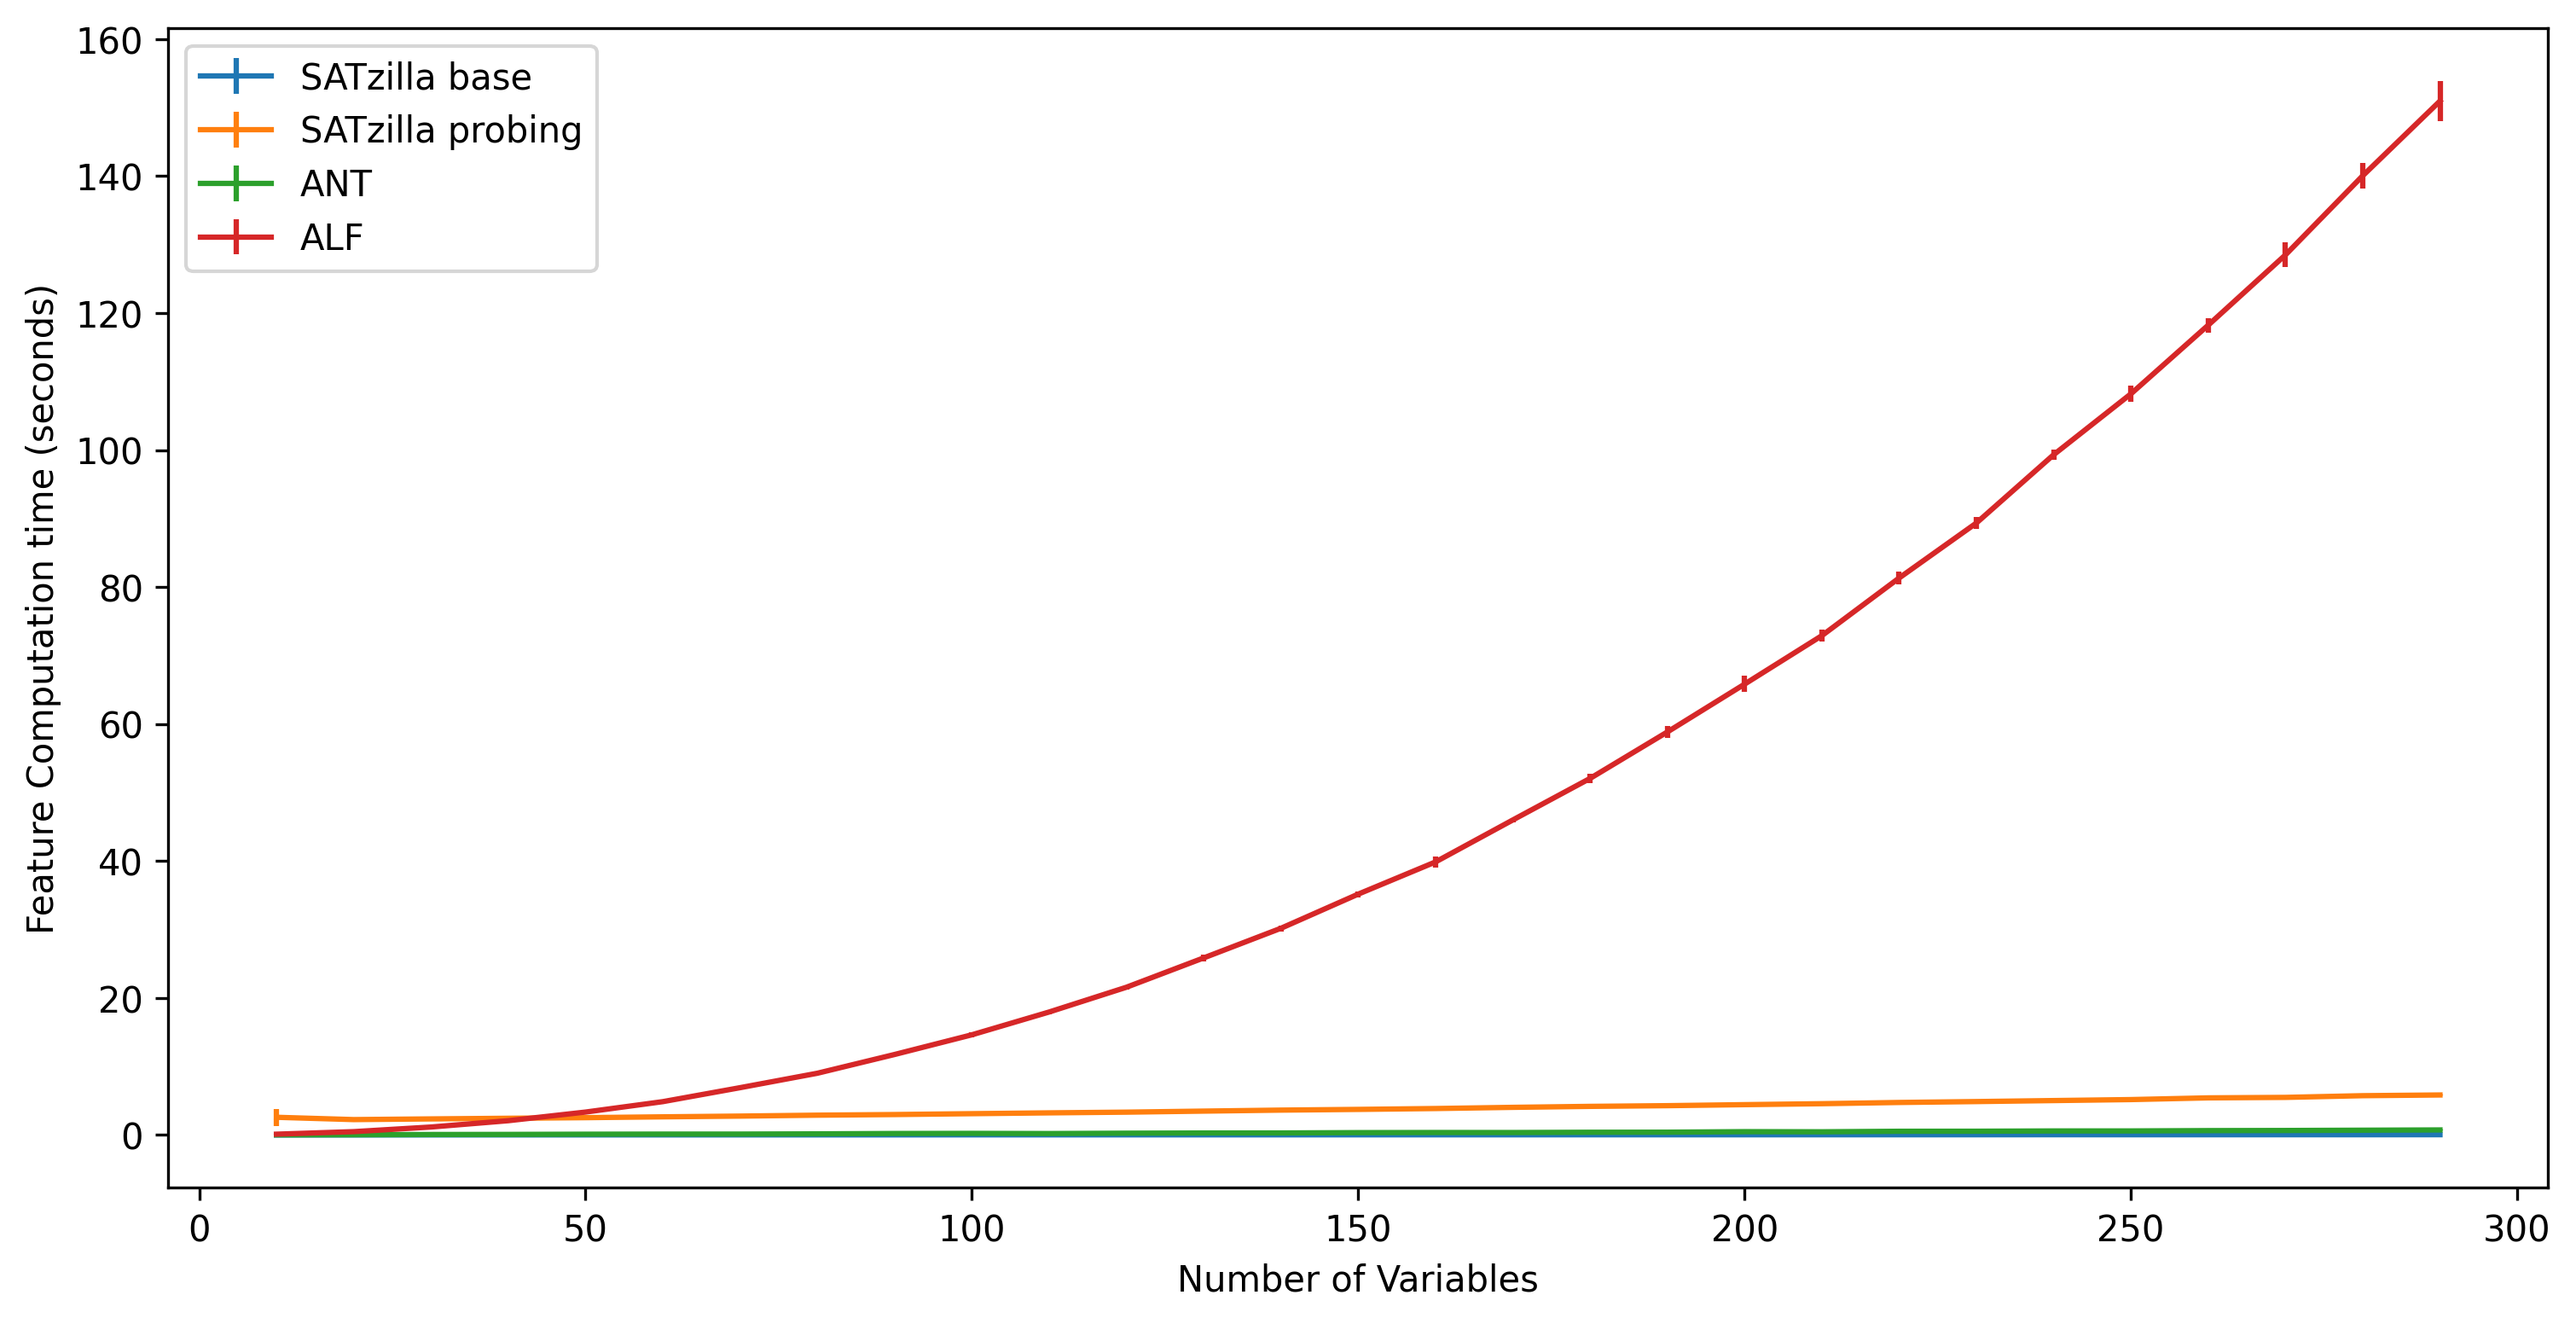

In [ ]:
timing = ['satzilla_base_t', 'satzilla_probe_t', 'ansotegui_t', 'alfonso_t']
timing_names = ["SATzilla base", "SATzilla probing", "ANT", "ALF"]


plt.figure(figsize = (12, 6), dpi = 300)
for i, time in enumerate(timing):
    Y = cnf_size.copy()
    X = df_rand[time]
    x,y,std = get_mean_std(X,Y)
    plt.errorbar(x, y, yerr=std, label=timing_names[i])
plt.legend(loc='upper left')

plt.xlabel("Number of Variables")
plt.ylabel("Feature Computation time (seconds)")
plt.savefig("time_v_size", bbox_inches="tight")
plt.show()